In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator



from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_addons as tfa
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam


In [2]:
TRAIN_DIR = '../data/cancerous/training'
TEST_DIR = '../data/cancerous/testing'
VAL_DIR = '../data/cancerous/validation'
# INPUT_WIDTH = 27
# INPUT_HEIGHT = 27

BATCH_SIZE = 128
IMG_SIZE = (32, 32)


train_dataset = image_dataset_from_directory(TRAIN_DIR,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             interpolation='bilinear',
                                             label_mode='categorical'
                                            )

validation_dataset = image_dataset_from_directory(VAL_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  interpolation='bilinear',
                                                  label_mode='categorical'
                                            )

test_dataset = image_dataset_from_directory(TEST_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  interpolation='bilinear',
                                                  label_mode='categorical'
                                            )

Found 16223 files belonging to 2 classes.
Found 2028 files belonging to 2 classes.
Found 2029 files belonging to 2 classes.


In [3]:
def get_class_name(class_num):
    if class_num == 0:
        return 'non-cancerous'
    elif class_num == 1:
        return 'cancerous'

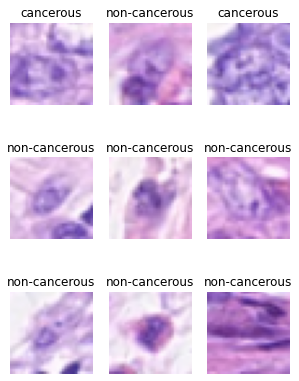

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(5, 7))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(get_class_name(tf.where(tf.equal(labels[i], 1)).numpy()[0][0]))
        plt.axis("off")

In [5]:
train_dataset.class_names

['0', '1']

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

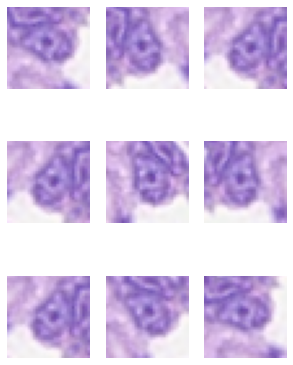

In [8]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(5, 7))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.axis('off')

In [10]:
# Create the base model from Resnet50V2 model without pre-trained weights
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [11]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 18, 18, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2)

In [13]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [15]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', f1_score ,precision_m, recall_m])

/home/trungngo/Desktop/venv/colon-cancer-classification/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [16]:
len(model.trainable_variables)

174

In [17]:
epochs = 500

loss0, accuracy0, f1_0, precision0, recall0 = model.evaluate(validation_dataset)

16/16 [==============================] - 3s 26ms/step - loss: 0.8291 - accuracy: 0.4389 - f1_score: 0.2844 - precision_m: 0.4380 - recall_m: 0.2109


In [18]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.83
initial accuracy: 0.44


In [19]:
import time
start_time = time.time()

In [20]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                   )

Epoch 1/500
127/127 [==============================] - 7s 30ms/step - loss: 0.4719 - accuracy: 0.7900 - f1_score: 0.7526 - precision_m: 0.8199 - recall_m: 0.6981 - val_loss: 0.3981 - val_accuracy: 0.8333 - val_f1_score: 0.8104 - val_precision_m: 0.8594 - val_recall_m: 0.7670
Epoch 2/500
127/127 [==============================] - 3s 24ms/step - loss: 0.3796 - accuracy: 0.8416 - f1_score: 0.8224 - precision_m: 0.8693 - recall_m: 0.7806 - val_loss: 0.3779 - val_accuracy: 0.8304 - val_f1_score: 0.8174 - val_precision_m: 0.8661 - val_recall_m: 0.7741
Epoch 3/500
127/127 [==============================] - 3s 25ms/step - loss: 0.3561 - accuracy: 0.8502 - f1_score: 0.8331 - precision_m: 0.8798 - recall_m: 0.7915 - val_loss: 0.3630 - val_accuracy: 0.8412 - val_f1_score: 0.8329 - val_precision_m: 0.8764 - val_recall_m: 0.7938
Epoch 4/500
127/127 [==============================] - 3s 24ms/step - loss: 0.3311 - accuracy: 0.8619 - f1_score: 0.8453 - precision_m: 0.8895 - recall_m: 0.8057 - val_loss

Epoch 31/500
127/127 [==============================] - 3s 24ms/step - loss: 0.2214 - accuracy: 0.9077 - f1_score: 0.9008 - precision_m: 0.9305 - recall_m: 0.8731 - val_loss: 0.2494 - val_accuracy: 0.8999 - val_f1_score: 0.8935 - val_precision_m: 0.9208 - val_recall_m: 0.8678
Epoch 32/500
127/127 [==============================] - 3s 24ms/step - loss: 0.2206 - accuracy: 0.9105 - f1_score: 0.9040 - precision_m: 0.9344 - recall_m: 0.8757 - val_loss: 0.2546 - val_accuracy: 0.8935 - val_f1_score: 0.8856 - val_precision_m: 0.9140 - val_recall_m: 0.8591
Epoch 33/500
127/127 [==============================] - 3s 24ms/step - loss: 0.2199 - accuracy: 0.9088 - f1_score: 0.9014 - precision_m: 0.9326 - recall_m: 0.8724 - val_loss: 0.2535 - val_accuracy: 0.9038 - val_f1_score: 0.8946 - val_precision_m: 0.9225 - val_recall_m: 0.8685
Epoch 34/500
127/127 [==============================] - 3s 25ms/step - loss: 0.2198 - accuracy: 0.9098 - f1_score: 0.9020 - precision_m: 0.9336 - recall_m: 0.8728 - val_

Epoch 61/500
127/127 [==============================] - 3s 25ms/step - loss: 0.1628 - accuracy: 0.9333 - f1_score: 0.9315 - precision_m: 0.9515 - recall_m: 0.9125 - val_loss: 0.2257 - val_accuracy: 0.9122 - val_f1_score: 0.9129 - val_precision_m: 0.9320 - val_recall_m: 0.8947
Epoch 62/500
127/127 [==============================] - 3s 25ms/step - loss: 0.1602 - accuracy: 0.9351 - f1_score: 0.9311 - precision_m: 0.9513 - recall_m: 0.9119 - val_loss: 0.2326 - val_accuracy: 0.9098 - val_f1_score: 0.9112 - val_precision_m: 0.9284 - val_recall_m: 0.8947
Epoch 63/500
127/127 [==============================] - 3s 24ms/step - loss: 0.1595 - accuracy: 0.9352 - f1_score: 0.9308 - precision_m: 0.9524 - recall_m: 0.9102 - val_loss: 0.2451 - val_accuracy: 0.9034 - val_f1_score: 0.9039 - val_precision_m: 0.9214 - val_recall_m: 0.8873
Epoch 64/500
127/127 [==============================] - 3s 24ms/step - loss: 0.1585 - accuracy: 0.9352 - f1_score: 0.9306 - precision_m: 0.9517 - recall_m: 0.9106 - val_

Epoch 91/500
127/127 [==============================] - 3s 25ms/step - loss: 0.1150 - accuracy: 0.9553 - f1_score: 0.9522 - precision_m: 0.9667 - recall_m: 0.9384 - val_loss: 0.2494 - val_accuracy: 0.9236 - val_f1_score: 0.9220 - val_precision_m: 0.9345 - val_recall_m: 0.9099
Epoch 92/500
127/127 [==============================] - 3s 26ms/step - loss: 0.1164 - accuracy: 0.9538 - f1_score: 0.9514 - precision_m: 0.9657 - recall_m: 0.9375 - val_loss: 0.2439 - val_accuracy: 0.9196 - val_f1_score: 0.9174 - val_precision_m: 0.9305 - val_recall_m: 0.9049
Epoch 93/500
127/127 [==============================] - 3s 24ms/step - loss: 0.1131 - accuracy: 0.9548 - f1_score: 0.9528 - precision_m: 0.9671 - recall_m: 0.9390 - val_loss: 0.2558 - val_accuracy: 0.9142 - val_f1_score: 0.9127 - val_precision_m: 0.9253 - val_recall_m: 0.9006
Epoch 94/500
127/127 [==============================] - 3s 25ms/step - loss: 0.1089 - accuracy: 0.9575 - f1_score: 0.9546 - precision_m: 0.9688 - recall_m: 0.9409 - val_

127/127 [==============================] - 3s 23ms/step - loss: 0.0804 - accuracy: 0.9707 - f1_score: 0.9680 - precision_m: 0.9776 - recall_m: 0.9587 - val_loss: 0.2839 - val_accuracy: 0.9216 - val_f1_score: 0.9183 - val_precision_m: 0.9301 - val_recall_m: 0.9070
Epoch 121/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0773 - accuracy: 0.9704 - f1_score: 0.9681 - precision_m: 0.9767 - recall_m: 0.9597 - val_loss: 0.2852 - val_accuracy: 0.9172 - val_f1_score: 0.9138 - val_precision_m: 0.9230 - val_recall_m: 0.9049
Epoch 122/500
127/127 [==============================] - 3s 24ms/step - loss: 0.0758 - accuracy: 0.9703 - f1_score: 0.9693 - precision_m: 0.9776 - recall_m: 0.9613 - val_loss: 0.3043 - val_accuracy: 0.9103 - val_f1_score: 0.9094 - val_precision_m: 0.9202 - val_recall_m: 0.8989
Epoch 123/500
127/127 [==============================] - 3s 23ms/step - loss: 0.0733 - accuracy: 0.9713 - f1_score: 0.9702 - precision_m: 0.9786 - recall_m: 0.9620 - val_loss: 0.30

127/127 [==============================] - 3s 25ms/step - loss: 0.0568 - accuracy: 0.9788 - f1_score: 0.9780 - precision_m: 0.9841 - recall_m: 0.9719 - val_loss: 0.3520 - val_accuracy: 0.9127 - val_f1_score: 0.9108 - val_precision_m: 0.9183 - val_recall_m: 0.9036
Epoch 150/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0510 - accuracy: 0.9810 - f1_score: 0.9804 - precision_m: 0.9863 - recall_m: 0.9745 - val_loss: 0.3393 - val_accuracy: 0.9157 - val_f1_score: 0.9135 - val_precision_m: 0.9236 - val_recall_m: 0.9036
Epoch 151/500
127/127 [==============================] - 3s 23ms/step - loss: 0.0517 - accuracy: 0.9814 - f1_score: 0.9799 - precision_m: 0.9856 - recall_m: 0.9742 - val_loss: 0.3312 - val_accuracy: 0.9206 - val_f1_score: 0.9185 - val_precision_m: 0.9254 - val_recall_m: 0.9117
Epoch 152/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0532 - accuracy: 0.9804 - f1_score: 0.9793 - precision_m: 0.9842 - recall_m: 0.9745 - val_loss: 0.32

127/127 [==============================] - 3s 24ms/step - loss: 0.0395 - accuracy: 0.9852 - f1_score: 0.9846 - precision_m: 0.9891 - recall_m: 0.9802 - val_loss: 0.3525 - val_accuracy: 0.9112 - val_f1_score: 0.9090 - val_precision_m: 0.9186 - val_recall_m: 0.8996
Epoch 179/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0417 - accuracy: 0.9852 - f1_score: 0.9840 - precision_m: 0.9886 - recall_m: 0.9795 - val_loss: 0.3747 - val_accuracy: 0.9157 - val_f1_score: 0.9135 - val_precision_m: 0.9221 - val_recall_m: 0.9052
Epoch 180/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0413 - accuracy: 0.9848 - f1_score: 0.9836 - precision_m: 0.9883 - recall_m: 0.9789 - val_loss: 0.3360 - val_accuracy: 0.9152 - val_f1_score: 0.9156 - val_precision_m: 0.9247 - val_recall_m: 0.9067
Epoch 181/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0383 - accuracy: 0.9851 - f1_score: 0.9841 - precision_m: 0.9889 - recall_m: 0.9795 - val_loss: 0.38

127/127 [==============================] - 3s 26ms/step - loss: 0.0324 - accuracy: 0.9882 - f1_score: 0.9878 - precision_m: 0.9913 - recall_m: 0.9844 - val_loss: 0.3776 - val_accuracy: 0.9181 - val_f1_score: 0.9169 - val_precision_m: 0.9247 - val_recall_m: 0.9092
Epoch 208/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0358 - accuracy: 0.9863 - f1_score: 0.9861 - precision_m: 0.9899 - recall_m: 0.9824 - val_loss: 0.4009 - val_accuracy: 0.9122 - val_f1_score: 0.9098 - val_precision_m: 0.9185 - val_recall_m: 0.9013
Epoch 209/500
127/127 [==============================] - 3s 26ms/step - loss: 0.0356 - accuracy: 0.9871 - f1_score: 0.9869 - precision_m: 0.9901 - recall_m: 0.9837 - val_loss: 0.4018 - val_accuracy: 0.9167 - val_f1_score: 0.9138 - val_precision_m: 0.9199 - val_recall_m: 0.9078
Epoch 210/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0298 - accuracy: 0.9893 - f1_score: 0.9889 - precision_m: 0.9921 - recall_m: 0.9857 - val_loss: 0.40

127/127 [==============================] - 3s 25ms/step - loss: 0.0244 - accuracy: 0.9906 - f1_score: 0.9905 - precision_m: 0.9932 - recall_m: 0.9879 - val_loss: 0.4070 - val_accuracy: 0.9241 - val_f1_score: 0.9228 - val_precision_m: 0.9281 - val_recall_m: 0.9176
Epoch 237/500
127/127 [==============================] - 3s 24ms/step - loss: 0.0270 - accuracy: 0.9909 - f1_score: 0.9903 - precision_m: 0.9930 - recall_m: 0.9877 - val_loss: 0.3931 - val_accuracy: 0.9216 - val_f1_score: 0.9202 - val_precision_m: 0.9253 - val_recall_m: 0.9153
Epoch 238/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0321 - accuracy: 0.9887 - f1_score: 0.9884 - precision_m: 0.9915 - recall_m: 0.9853 - val_loss: 0.3709 - val_accuracy: 0.9216 - val_f1_score: 0.9200 - val_precision_m: 0.9277 - val_recall_m: 0.9126
Epoch 239/500
127/127 [==============================] - 3s 24ms/step - loss: 0.0231 - accuracy: 0.9911 - f1_score: 0.9908 - precision_m: 0.9934 - recall_m: 0.9883 - val_loss: 0.39

127/127 [==============================] - 3s 25ms/step - loss: 0.0225 - accuracy: 0.9914 - f1_score: 0.9911 - precision_m: 0.9934 - recall_m: 0.9889 - val_loss: 0.4087 - val_accuracy: 0.9216 - val_f1_score: 0.9222 - val_precision_m: 0.9280 - val_recall_m: 0.9165
Epoch 266/500
127/127 [==============================] - 3s 24ms/step - loss: 0.0230 - accuracy: 0.9924 - f1_score: 0.9914 - precision_m: 0.9935 - recall_m: 0.9893 - val_loss: 0.4422 - val_accuracy: 0.9137 - val_f1_score: 0.9161 - val_precision_m: 0.9231 - val_recall_m: 0.9092
Epoch 267/500
127/127 [==============================] - 3s 24ms/step - loss: 0.0216 - accuracy: 0.9916 - f1_score: 0.9915 - precision_m: 0.9937 - recall_m: 0.9893 - val_loss: 0.3893 - val_accuracy: 0.9231 - val_f1_score: 0.9224 - val_precision_m: 0.9284 - val_recall_m: 0.9166
Epoch 268/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0213 - accuracy: 0.9927 - f1_score: 0.9926 - precision_m: 0.9949 - recall_m: 0.9903 - val_loss: 0.46

127/127 [==============================] - 3s 24ms/step - loss: 0.0223 - accuracy: 0.9922 - f1_score: 0.9916 - precision_m: 0.9938 - recall_m: 0.9895 - val_loss: 0.4282 - val_accuracy: 0.9246 - val_f1_score: 0.9231 - val_precision_m: 0.9303 - val_recall_m: 0.9162
Epoch 295/500
127/127 [==============================] - 3s 24ms/step - loss: 0.0210 - accuracy: 0.9919 - f1_score: 0.9917 - precision_m: 0.9939 - recall_m: 0.9895 - val_loss: 0.4160 - val_accuracy: 0.9216 - val_f1_score: 0.9195 - val_precision_m: 0.9266 - val_recall_m: 0.9126
Epoch 296/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0174 - accuracy: 0.9938 - f1_score: 0.9939 - precision_m: 0.9958 - recall_m: 0.9920 - val_loss: 0.4401 - val_accuracy: 0.9162 - val_f1_score: 0.9129 - val_precision_m: 0.9186 - val_recall_m: 0.9074
Epoch 297/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0219 - accuracy: 0.9922 - f1_score: 0.9923 - precision_m: 0.9943 - recall_m: 0.9903 - val_loss: 0.40

127/127 [==============================] - 3s 23ms/step - loss: 0.0206 - accuracy: 0.9921 - f1_score: 0.9919 - precision_m: 0.9935 - recall_m: 0.9903 - val_loss: 0.4453 - val_accuracy: 0.9196 - val_f1_score: 0.9186 - val_precision_m: 0.9257 - val_recall_m: 0.9116
Epoch 324/500
127/127 [==============================] - 3s 24ms/step - loss: 0.0183 - accuracy: 0.9933 - f1_score: 0.9932 - precision_m: 0.9949 - recall_m: 0.9915 - val_loss: 0.4280 - val_accuracy: 0.9246 - val_f1_score: 0.9239 - val_precision_m: 0.9308 - val_recall_m: 0.9172
Epoch 325/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0205 - accuracy: 0.9925 - f1_score: 0.9920 - precision_m: 0.9944 - recall_m: 0.9896 - val_loss: 0.4408 - val_accuracy: 0.9211 - val_f1_score: 0.9199 - val_precision_m: 0.9252 - val_recall_m: 0.9147
Epoch 326/500
127/127 [==============================] - 3s 24ms/step - loss: 0.0181 - accuracy: 0.9938 - f1_score: 0.9934 - precision_m: 0.9954 - recall_m: 0.9915 - val_loss: 0.44

127/127 [==============================] - 3s 24ms/step - loss: 0.0174 - accuracy: 0.9937 - f1_score: 0.9930 - precision_m: 0.9951 - recall_m: 0.9910 - val_loss: 0.4569 - val_accuracy: 0.9241 - val_f1_score: 0.9235 - val_precision_m: 0.9296 - val_recall_m: 0.9174
Epoch 353/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0173 - accuracy: 0.9939 - f1_score: 0.9935 - precision_m: 0.9956 - recall_m: 0.9914 - val_loss: 0.4736 - val_accuracy: 0.9236 - val_f1_score: 0.9214 - val_precision_m: 0.9288 - val_recall_m: 0.9141
Epoch 354/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0151 - accuracy: 0.9947 - f1_score: 0.9942 - precision_m: 0.9959 - recall_m: 0.9924 - val_loss: 0.4875 - val_accuracy: 0.9206 - val_f1_score: 0.9193 - val_precision_m: 0.9259 - val_recall_m: 0.9128
Epoch 355/500
127/127 [==============================] - 3s 24ms/step - loss: 0.0119 - accuracy: 0.9961 - f1_score: 0.9960 - precision_m: 0.9971 - recall_m: 0.9949 - val_loss: 0.50

127/127 [==============================] - 3s 25ms/step - loss: 0.0131 - accuracy: 0.9948 - f1_score: 0.9945 - precision_m: 0.9956 - recall_m: 0.9935 - val_loss: 0.4498 - val_accuracy: 0.9216 - val_f1_score: 0.9224 - val_precision_m: 0.9262 - val_recall_m: 0.9186
Epoch 382/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0148 - accuracy: 0.9948 - f1_score: 0.9946 - precision_m: 0.9961 - recall_m: 0.9930 - val_loss: 0.4706 - val_accuracy: 0.9191 - val_f1_score: 0.9202 - val_precision_m: 0.9262 - val_recall_m: 0.9144
Epoch 383/500
127/127 [==============================] - 3s 24ms/step - loss: 0.0123 - accuracy: 0.9959 - f1_score: 0.9955 - precision_m: 0.9970 - recall_m: 0.9941 - val_loss: 0.4827 - val_accuracy: 0.9196 - val_f1_score: 0.9190 - val_precision_m: 0.9230 - val_recall_m: 0.9150
Epoch 384/500
127/127 [==============================] - 3s 24ms/step - loss: 0.0198 - accuracy: 0.9938 - f1_score: 0.9935 - precision_m: 0.9952 - recall_m: 0.9918 - val_loss: 0.40

127/127 [==============================] - 3s 25ms/step - loss: 0.0166 - accuracy: 0.9942 - f1_score: 0.9941 - precision_m: 0.9954 - recall_m: 0.9927 - val_loss: 0.4684 - val_accuracy: 0.9191 - val_f1_score: 0.9165 - val_precision_m: 0.9218 - val_recall_m: 0.9112
Epoch 411/500
127/127 [==============================] - 3s 23ms/step - loss: 0.0148 - accuracy: 0.9943 - f1_score: 0.9942 - precision_m: 0.9956 - recall_m: 0.9929 - val_loss: 0.4565 - val_accuracy: 0.9196 - val_f1_score: 0.9187 - val_precision_m: 0.9244 - val_recall_m: 0.9130
Epoch 412/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0133 - accuracy: 0.9953 - f1_score: 0.9953 - precision_m: 0.9963 - recall_m: 0.9943 - val_loss: 0.5116 - val_accuracy: 0.9122 - val_f1_score: 0.9102 - val_precision_m: 0.9150 - val_recall_m: 0.9054
Epoch 413/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0143 - accuracy: 0.9950 - f1_score: 0.9948 - precision_m: 0.9959 - recall_m: 0.9937 - val_loss: 0.49

127/127 [==============================] - 3s 24ms/step - loss: 0.0111 - accuracy: 0.9961 - f1_score: 0.9961 - precision_m: 0.9972 - recall_m: 0.9951 - val_loss: 0.4330 - val_accuracy: 0.9295 - val_f1_score: 0.9260 - val_precision_m: 0.9335 - val_recall_m: 0.9186
Epoch 440/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0123 - accuracy: 0.9948 - f1_score: 0.9951 - precision_m: 0.9966 - recall_m: 0.9937 - val_loss: 0.4574 - val_accuracy: 0.9216 - val_f1_score: 0.9210 - val_precision_m: 0.9259 - val_recall_m: 0.9163
Epoch 441/500
127/127 [==============================] - 3s 24ms/step - loss: 0.0106 - accuracy: 0.9961 - f1_score: 0.9958 - precision_m: 0.9968 - recall_m: 0.9948 - val_loss: 0.4697 - val_accuracy: 0.9246 - val_f1_score: 0.9246 - val_precision_m: 0.9310 - val_recall_m: 0.9183
Epoch 442/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0120 - accuracy: 0.9957 - f1_score: 0.9955 - precision_m: 0.9967 - recall_m: 0.9943 - val_loss: 0.48

127/127 [==============================] - 3s 24ms/step - loss: 0.0123 - accuracy: 0.9957 - f1_score: 0.9955 - precision_m: 0.9967 - recall_m: 0.9943 - val_loss: 0.4930 - val_accuracy: 0.9211 - val_f1_score: 0.9199 - val_precision_m: 0.9265 - val_recall_m: 0.9135
Epoch 469/500
127/127 [==============================] - 3s 24ms/step - loss: 0.0134 - accuracy: 0.9953 - f1_score: 0.9951 - precision_m: 0.9962 - recall_m: 0.9940 - val_loss: 0.4884 - val_accuracy: 0.9250 - val_f1_score: 0.9237 - val_precision_m: 0.9289 - val_recall_m: 0.9186
Epoch 470/500
127/127 [==============================] - 3s 25ms/step - loss: 0.0104 - accuracy: 0.9960 - f1_score: 0.9960 - precision_m: 0.9971 - recall_m: 0.9949 - val_loss: 0.5290 - val_accuracy: 0.9206 - val_f1_score: 0.9186 - val_precision_m: 0.9241 - val_recall_m: 0.9132
Epoch 471/500
127/127 [==============================] - 3s 23ms/step - loss: 0.0134 - accuracy: 0.9952 - f1_score: 0.9951 - precision_m: 0.9962 - recall_m: 0.9940 - val_loss: 0.47

127/127 [==============================] - 3s 24ms/step - loss: 0.0110 - accuracy: 0.9967 - f1_score: 0.9964 - precision_m: 0.9975 - recall_m: 0.9954 - val_loss: 0.5159 - val_accuracy: 0.9196 - val_f1_score: 0.9180 - val_precision_m: 0.9214 - val_recall_m: 0.9146
Epoch 498/500
127/127 [==============================] - 3s 26ms/step - loss: 0.0080 - accuracy: 0.9971 - f1_score: 0.9970 - precision_m: 0.9978 - recall_m: 0.9962 - val_loss: 0.5165 - val_accuracy: 0.9186 - val_f1_score: 0.9181 - val_precision_m: 0.9235 - val_recall_m: 0.9129
Epoch 499/500
127/127 [==============================] - 3s 24ms/step - loss: 0.0107 - accuracy: 0.9963 - f1_score: 0.9961 - precision_m: 0.9968 - recall_m: 0.9954 - val_loss: 0.5074 - val_accuracy: 0.9157 - val_f1_score: 0.9162 - val_precision_m: 0.9209 - val_recall_m: 0.9115
Epoch 500/500
127/127 [==============================] - 3s 24ms/step - loss: 0.0093 - accuracy: 0.9968 - f1_score: 0.9965 - precision_m: 0.9976 - recall_m: 0.9954 - val_loss: 0.50

In [21]:
print("---  Training time in seconds ---%s " % (time.time() - start_time))

---  Training time in seconds ---1569.6914820671082 


In [22]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_dataset)

16/16 [==============================] - 0s 26ms/step - loss: 0.3992 - accuracy: 0.9320 - f1_score: 0.9308 - precision_m: 0.9384 - recall_m: 0.9235


In [23]:
model.save('Resnet50V2-cancerous-classification.hdf5')

/home/trungngo/Desktop/venv/colon-cancer-classification/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


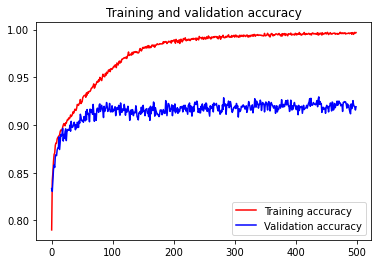

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

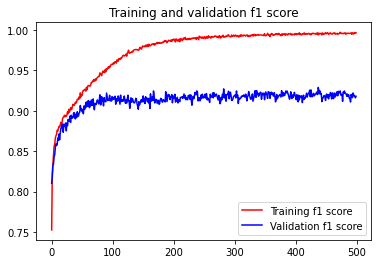

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

epochs = range(len(f1))

plt.plot(epochs, f1, 'r', label='Training f1 score')
plt.plot(epochs, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.legend(loc=0)
plt.figure()


plt.show()

In [26]:
# print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test F1 score', f1_score)

Test accuracy: 0.9319862127304077
Test F1 score 0.9308039546012878


In [27]:
print('Max validation accuracy:', max(history.history['val_accuracy']))

Max validation accuracy: 0.9294871687889099


In [28]:
print('Max training accuracy:', max(history.history['accuracy']))

Max training accuracy: 0.9972261786460876


In [29]:
print('Max validation F1 score:', max(history.history['val_f1_score']))

Max validation F1 score: 0.9290066957473755


In [30]:
print('Max training F1 score:', max(history.history['f1_score']))

Max training F1 score: 0.9973193407058716
